In [11]:
import pandas as pd
import pandas_datareader as pdr 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stock_analysis import StockReader

In [12]:
start_date = '2014-01-01'
end_date = '2024-01-01'
reader = StockReader(start_date, end_date)

In [13]:
qqq = reader.get_ticker_data('QQQ')
del qqq['open']
del qqq['high']
del qqq['low']
del qqq['close']
del qqq['volume']

In [14]:
# shape QQQ data
qqq.pct_change()
qqq.dropna()
qqq_mtl = qqq.resample('M').agg(lambda x: (x[-1] / x[0] - 1))
qqq_mtl.rename(columns={'adj_close': 'return'}, inplace=True)

qqq_mtl['date'] = qqq_mtl.index.strftime('%Y-%m')
qqq_mtl = qqq_mtl.set_index('date')

# saves to csv
qqq.to_csv('qqq_data/qqq_monthly_returns.csv')

qqq_mtl.head()

/var/folders/1t/kxr4zm9j0p79ykn_b_ms5zsc0000gn/T/ipykernel_73040/2691700977.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qqq_mtl = qqq.resample('M').agg(lambda x: (x[-1] / x[0] - 1))


,return
date,
2014-01,-0.011459
2014-02,0.076225
2014-03,-0.020068
2014-04,-0.020402
2014-05,0.041757


In [15]:
# get Fama-French factors data using API call
factors = pdr.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=start_date)[0]

# convert factors to decimal
factors[['Mkt-RF', 'SMB', 'HML', 'RF']] = factors[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100

factors.head()

/var/folders/1t/kxr4zm9j0p79ykn_b_ms5zsc0000gn/T/ipykernel_73040/2042816857.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = pdr.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=start_date)[0]
/var/folders/1t/kxr4zm9j0p79ykn_b_ms5zsc0000gn/T/ipykernel_73040/2042816857.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = pdr.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=start_date)[0]


,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2014-01,-0.0332,0.0058,-0.0207,-3.88,-1.42,0.0
2014-02,0.0465,0.0014,-0.0031,-0.23,-0.45,0.0
2014-03,0.0043,-0.0109,0.0493,2.13,1.92,0.0
2014-04,-0.0019,-0.0412,0.0117,3.48,1.02,0.0
2014-05,0.0206,-0.0189,-0.0013,0.05,-1.00,0.0


In [16]:
# adjust indices
qqq_mtl.index = factors.index

In [17]:
# merge data
merge = pd.merge(qqq_mtl,factors,left_index=True, right_index=True)
merge.to_csv('qqq_data/merged_data.csv')
merge.tail()

,return,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,
2023-08,-0.012540,-0.0239,-0.0365,-0.0106,3.43,-2.37,0.0045
2023-09,-0.049793,-0.0524,-0.0180,0.0152,1.86,-0.83,0.0043
2023-10,-0.028760,-0.0319,-0.0404,0.0019,2.46,-0.66,0.0047
2023-11,0.089282,0.0884,-0.0012,0.0164,-3.91,-1.00,0.0044
2023-12,0.052864,0.0485,0.0732,0.0494,-3.07,1.32,0.0043


In [18]:
merge['residual_return'] = merge['return'] - merge['RF']
merge.tail()

,return,Mkt-RF,SMB,HML,RMW,CMA,RF,residual_return
Date,,,,,,,,
2023-08,-0.012540,-0.0239,-0.0365,-0.0106,3.43,-2.37,0.0045,-0.017040
2023-09,-0.049793,-0.0524,-0.0180,0.0152,1.86,-0.83,0.0043,-0.054093
2023-10,-0.028760,-0.0319,-0.0404,0.0019,2.46,-0.66,0.0047,-0.033460
2023-11,0.089282,0.0884,-0.0012,0.0164,-3.91,-1.00,0.0044,0.084882
2023-12,0.052864,0.0485,0.0732,0.0494,-3.07,1.32,0.0043,0.048564


## Regression Statistics and Results

### Fama French's Five Factor Model Equation

![fivefactor_equation.png](images/fivefactor_equation.png)


In [19]:
# prepare data for regression
y = merge['residual_return']
X = merge[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

X_sm = sm.add_constant(X)

# regression
model = sm.OLS(y, X_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        residual_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     184.7
Date:                Tue, 13 Feb 2024   Prob (F-statistic):           5.98e-53
Time:                        22:40:27   Log-Likelihood:                 309.58
No. Observations:                 120   AIC:                            -607.2
Df Residuals:                     114   BIC:                            -590.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.618      0.5

### Results

Based on the regression analysis of the Fama French five-factor model for the QQQ index fund from 2014-2024, the following results were obtained:

1. **R-Squared Statistic**: The R-squared statistic is 89%, indicating that approximately 89% of the variance in the QQQ index fund's residual return is explained by the independent variables in the model.

2. **Alpha (const)**: The alpha (constant) is 0.0011. Positive monthly alphas suggest good performance of the QQQ index fund.

3. **Market Risk Premium (Mkt-RF)**: The coefficient for the market risk premium (Mkt-RF) is 1.1238. A beta greater than 1 (1.1238) indicates that the fund has higher volatility compared to the market.

4. **Size (SMB)**: The coefficient for size (SMB) is -0.1436. A negative coefficient suggests that the fund tends to invest more in larger stocks.

5. **Value (HML)**: The coefficient for value (HML) is -0.3056. A negative coefficient indicates that the fund tends to invest more in growth stocks, which aligns with the objective of the QQQ growth fund.

6. **Operating Profitability (RMW)**: The coefficient for operating profitability (RMW) is 6.063e-05. This coefficient is not statistically significant, suggesting that operating profitability may not have a significant impact on the QQQ index fund's performance during this period.

7. **Investment (CMA)**: The coefficient for investment (CMA) is -0.0014. Similar to operating profitability, this coefficient is not statistically significant, indicating that investment may not have a significant impact on the QQQ index fund's performance.


### Visualization

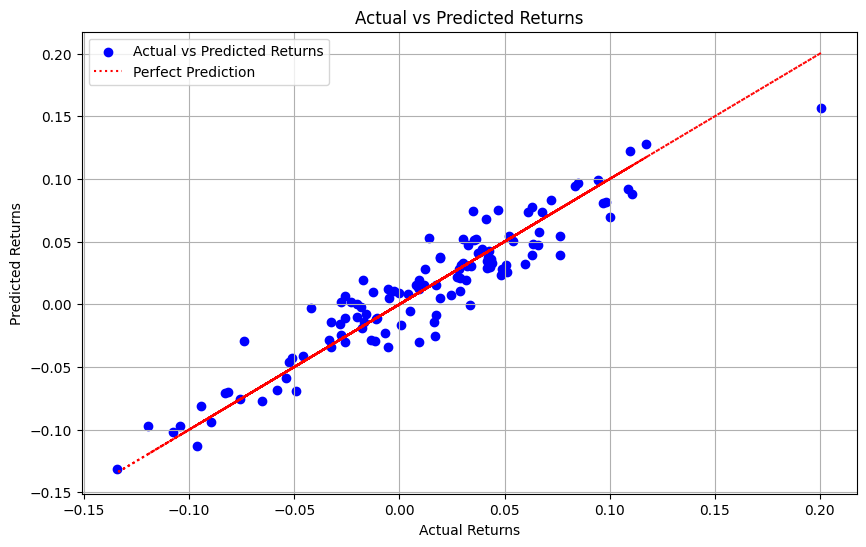

In [20]:
# plot actual vs predicted returns
plt.figure(figsize=(10, 6))
plt.scatter(y, model.predict(X_sm), color='blue', label='Actual vs Predicted Returns')
plt.plot(y, y, color='red', linestyle=':', label='Perfect Prediction')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.legend()
plt.grid(True)
plt.savefig('qqq_data/actual_vs_predicted_returns.png')
plt.show()